In [23]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import re
from tqdm import tqdm

# Define paths and constants
results_dir = "../results/num_init_iters"
lmax = 5

# Dictionary to store results by number of iterations
best_pred_by_iters = {}

# Get all files in the directory
files = os.listdir(results_dir)
# Filter out non-pickle files
files = [f for f in files if f.endswith('.pkl')]

# Sort files to process 0_500 batch before 500_1000 for each num_init_iters
def sort_key(filename):
    # Extract num_init_iters and batch info
    match = re.search(r'num_init_iters_(\d+)_batch_(\d+)_(\d+)', filename)
    if match:
        num_init_iters = int(match.group(1))
        batch_start = int(match.group(2))
        # Return a tuple for sorting: (num_init_iters, batch_start)
        return (num_init_iters, batch_start)
    return (float('inf'), float('inf'))  # For files that don't match pattern

# Sort files based on num_init_iters and batch order
sorted_files = sorted(files, key=sort_key)

# Process each file
for filename in tqdm(sorted_files):
    if filename == '.DS_Store':
        continue
        
    # Extract num_init_iters from filename using regex
    match = re.search(r'num_init_iters_(\d+)_batch', filename)
    if match:
        num_init_iters = int(match.group(1))
        filepath = os.path.join(results_dir, filename)
        
        try:
            with open(filepath, "rb") as f:
                batch_results = pickle.load(f)
                
                # Initialize the list for this num_init_iters if it doesn't exist
                if num_init_iters not in best_pred_by_iters:
                    best_pred_by_iters[num_init_iters] = []
                
                # Add best_pred to the appropriate list
                if "best_preds" in batch_results:
                    best_pred_by_iters[num_init_iters].extend(batch_results["best_preds"])
                else:
                    print(f"Warning: 'best_preds' not found in {filepath}")
                    
        except Exception as e:
            print(f"Error loading {filepath}: {str(e)}")

# Sort the dictionary by keys (num_init_iters)
best_pred_by_iters = dict(sorted(best_pred_by_iters.items()))

# Print summary
print(f"Loaded data for {len(best_pred_by_iters)} different iteration counts:")
for num_iters, preds in best_pred_by_iters.items():
    print(f"  - {num_iters} iterations: {len(preds)} predictions")

100%|██████████| 48/48 [00:02<00:00, 21.28it/s]

Loaded data for 24 different iteration counts:
  - 500 iterations: 1000 predictions
  - 1000 iterations: 1000 predictions
  - 1500 iterations: 1000 predictions
  - 2000 iterations: 1000 predictions
  - 2500 iterations: 1000 predictions
  - 3000 iterations: 1000 predictions
  - 3500 iterations: 1000 predictions
  - 4000 iterations: 1000 predictions
  - 4500 iterations: 1000 predictions
  - 5000 iterations: 1000 predictions
  - 5500 iterations: 1000 predictions
  - 6000 iterations: 1000 predictions
  - 6500 iterations: 1000 predictions
  - 7000 iterations: 1000 predictions
  - 7500 iterations: 1000 predictions
  - 8000 iterations: 1000 predictions
  - 8500 iterations: 1000 predictions
  - 9000 iterations: 1000 predictions
  - 9500 iterations: 1000 predictions
  - 10000 iterations: 1000 predictions
  - 10500 iterations: 1000 predictions
  - 11000 iterations: 1000 predictions
  - 11500 iterations: 1000 predictions
  - 12000 iterations: 1000 predictions


In [24]:
with open('../data/qm9_local_envs_10000.pkl', 'rb') as f:
    local_envs = pickle.load(f)

print(f"Number of local environments: {len(local_envs)}")

Number of local environments: 10000


In [25]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_dir = os.path.join(project_root, 'src')
sys.path.append(src_dir)
import spectra as spectra
from utils.plotters import visualize_signal
from utils.alignment import sample_uniform_quaternion, find_best_random_quaternion, align_signals, choose_best_quaternion, loss_fn, quaternion_rotation_distance, rotate_points_quaternion, point_distance, find_best_random_quaternions
from utils.geometries import trigonal_plane, tetrahedron, trigonal_bipyramid
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
import numpy as np
from scipy.spatial.transform import Rotation
import itertools
from tqdm import tqdm


def align_predicted_geometry(true_geometry: np.ndarray,
                             predicted_geometry: np.ndarray
                            ) -> tuple[np.ndarray, float]:
    """
    Aligns `predicted_geometry` onto `true_geometry` using only a rigid-body rotation.
    Points are first sorted by distance from the origin, normalized to unit radius,
    then each pair of corresponding direction‐vectors is scaled by a different
    random weight (to break any geometric symmetry) before computing the optimal
    rotation. Assumes both inputs are centered at the origin.

    Parameters
    ----------
    true_geometry : (N, 3) array_like
        Reference point cloud, centered at the origin.
    predicted_geometry : (N, 3) array_like
        Point cloud to align, also centered.

    Returns
    -------
    aligned_predicted : (N, 3) ndarray
        The `predicted_geometry` rotated to best match `true_geometry`.
    rmsd : float
        The RMSD between the (weighted) direction‐vectors after optimal alignment.
    """
    # Convert inputs
    true_pts = np.asarray(true_geometry, dtype=float)
    pred_pts = np.asarray(predicted_geometry, dtype=float)
    if true_pts.shape != pred_pts.shape or true_pts.shape[1] != 3:
        raise ValueError("Both inputs must have shape (N, 3)")

    # Compute norms (radii) without sorting
    true_radii = np.linalg.norm(true_pts, axis=1)
    pred_radii = np.linalg.norm(pred_pts, axis=1)
    
    # Normalize to unit vectors directly without reordering
    true_dirs = true_pts / true_radii[:, None]
    pred_dirs = pred_pts / pred_radii[:, None]    

    # Generate a different random weight for each point to break symmetry
    # (e.g. uniform on [0,1) or any other distribution)
    weights = np.random.rand(true_dirs.shape[0], 1)

    # Scale both sets by the same per-point weights
    true_weighted = true_dirs * weights
    pred_weighted = pred_dirs * weights

    # Compute optimal rotation on weighted directions
    rot, rmsd = Rotation.align_vectors(true_weighted, pred_weighted)

    # Apply rotation back to the original predicted points
    pred_rotated = rot.apply(pred_pts)

    return pred_rotated, rmsd


def alignment_mae(true_geometry, predicted_geometry):

    if len(true_geometry) != len(predicted_geometry):
        return float('inf')

    # Try all permutations of the predicted geometry and select the one with lowest RMSD
    best_error = float('inf')
    best_aligned = None
    
    # Get all permutations of indices
    n_points = predicted_geometry.shape[0]
    for perm in itertools.permutations(range(n_points)):
        perm_predicted = predicted_geometry[list(perm)]
        aligned, _ = align_predicted_geometry(true_geometry, perm_predicted)
        error = jnp.mean(jnp.linalg.norm(aligned - true_geometry, axis=1))
        # error = np.mean(np.abs(aligned - true_geometry), axis=1)
        if error < best_error:
            best_error = error

    return best_error

In [26]:
mae_by_iters = {}

for num_iters in tqdm(best_pred_by_iters.keys()):
    maes = []
    for index, local_env in enumerate(local_envs[:1000]):
        mae = alignment_mae(local_env, best_pred_by_iters[num_iters][index])
        maes.append(mae)
    mae_by_iters[num_iters] = maes

  0%|          | 0/24 [00:00<?, ?it/s]/var/folders/7c/7cx32s8x1x32j9xw0z_x3y980000gn/T/ipykernel_3400/4142812704.py:66: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rot, rmsd = Rotation.align_vectors(true_weighted, pred_weighted)
100%|██████████| 24/24 [00:23<00:00,  1.00it/s]


In [33]:
mae_by_iters.keys()

dict_keys([500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000])

In [35]:
len(mae_by_iters[1000])

1000

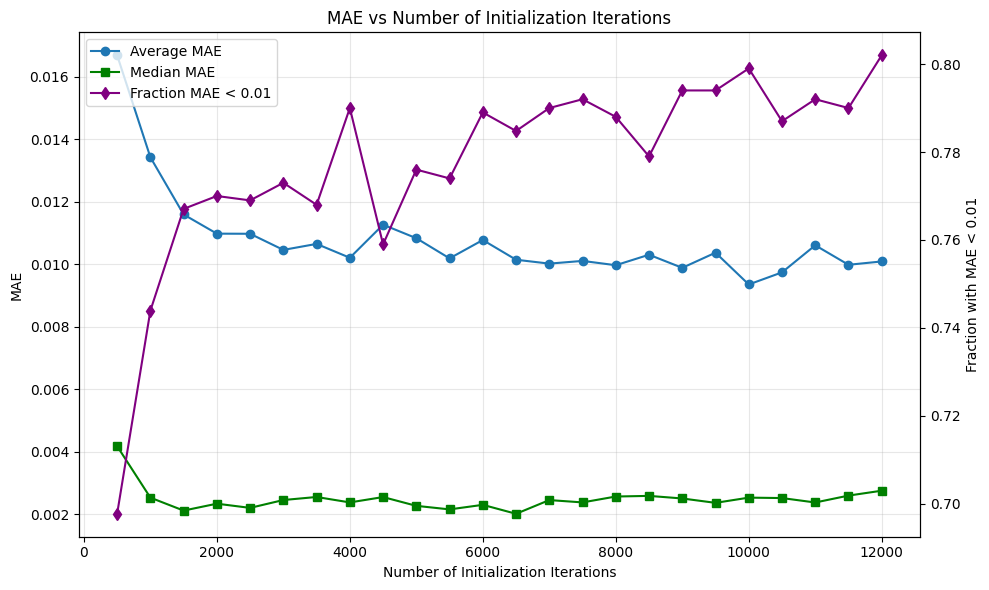

In [32]:
# Visualize the results
fig, ax1 = plt.figure(figsize=(10, 6)), plt.gca()

# Plot MAE for different numbers of iterations
iters_list = sorted(mae_by_iters.keys())
avg_maes = [np.mean([mae for mae in mae_by_iters[iters] if not np.isinf(mae)]) for iters in iters_list]
median_maes = [np.median([mae for mae in mae_by_iters[iters] if not np.isinf(mae)]) for iters in iters_list]
max_maes = [np.max([mae for mae in mae_by_iters[iters] if not np.isinf(mae)]) for iters in iters_list]

# Plot average, median, and max MAE
ax1.plot(iters_list, avg_maes, 'o-', label='Average MAE')
ax1.plot(iters_list, median_maes, 's-', color='green', label='Median MAE')
# ax1.plot(iters_list, max_maes, '^-', color='red', label='Maximum MAE')

# Add labels and title for first y-axis
ax1.set_xlabel('Number of Initialization Iterations')
ax1.set_ylabel('MAE')
ax1.tick_params(axis='y')

# Create second y-axis for fraction of structures with MAE < 0.01
ax2 = ax1.twinx()
fraction_good = [np.mean([mae < 0.01 for mae in mae_by_iters[iters] if not np.isinf(mae)]) for iters in iters_list]
ax2.plot(iters_list, fraction_good, 'd-', color='purple', label='Fraction MAE < 0.01')
ax2.set_ylabel('Fraction with MAE < 0.01')
ax2.tick_params(axis='y')

# Title and grid
plt.title('MAE vs Number of Initialization Iterations')
ax1.grid(True, alpha=0.3)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

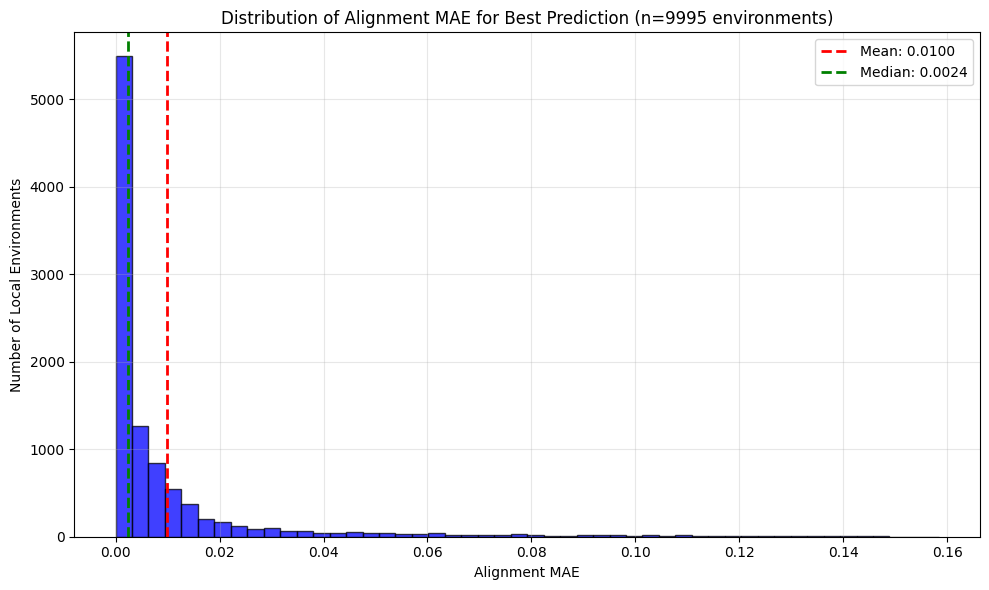

In [8]:
# Plot histogram of alignment MAE for the last (best) prediction
plt.figure(figsize=(10, 6))

# Get the MAE values for the last initialization (best prediction)
# Filter out inf values for better visualization
last_init_mae = best_alignment_mae_per_init[:, -1]
valid_mae = last_init_mae[~np.isinf(last_init_mae)]

# Create histogram
plt.hist(valid_mae, bins=50, alpha=0.75, color='blue', edgecolor='black')
plt.xlabel('Alignment MAE')
plt.ylabel('Number of Local Environments')
plt.title(f'Distribution of Alignment MAE for Best Prediction (n={len(valid_mae)} environments)')
plt.grid(True, alpha=0.3)

# Add statistics to the plot
plt.axvline(np.mean(valid_mae), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(valid_mae):.4f}')
plt.axvline(np.median(valid_mae), color='green', linestyle='dashed', linewidth=2, label=f'Median: {np.median(valid_mae):.4f}')

# Add legend
plt.legend()

plt.tight_layout()
plt.show()


In [61]:
# Count the number of False values in each column of mask
false_counts = np.sum(~mask, axis=0)
print("Number of False values in each column (initialization):")
for i, count in enumerate(false_counts):
    print(f"Initialization {i+1}: {count} False values")

Number of False values in each column (initialization):
Initialization 1: 56 False values
Initialization 2: 12 False values
Initialization 3: 4 False values
Initialization 4: 6 False values
Initialization 5: 4 False values
Initialization 6: 4 False values
Initialization 7: 4 False values
Initialization 8: 4 False values
Initialization 9: 3 False values
Initialization 10: 3 False values
Initialization 11: 4 False values
Initialization 12: 5 False values
Initialization 13: 5 False values
Initialization 14: 5 False values
Initialization 15: 5 False values
Initialization 16: 5 False values
Initialization 17: 5 False values
Initialization 18: 5 False values
Initialization 19: 5 False values
Initialization 20: 5 False values
